In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import Isomap
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy as sp
nlps = sp.load('en')
import random
plt.rc('figure',figsize=(17,13))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
kaggle datasets download -d gpreda/reddit-wallstreetsbets-posts

In [ ]:
r_data = pd.read_csv('reddit_wsb.csv')
r_data = r_data[pd.to_datetime(r_data.timestamp).dt.year>=2021]
r_data.head(3)


,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35


In [ ]:
title_data = r_data[['title','timestamp']].copy()
body_data = r_data[['body','timestamp']].copy()
body_data = body_data.dropna()
title_data = title_data.dropna()


title_data.title =title_data.title.str.lower()
body_data.body =body_data.body.str.lower()

#Remove handlers
title_data.title = title_data.title.apply(lambda x:re.sub('@[^\s]+','',x))
body_data.body   = body_data.body.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove URLS
title_data.title = title_data.title.apply(lambda x:re.sub(r"http\S+", "", x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
title_data.title = title_data.title.apply(lambda x:' '.join(re.findall(r'\w+', x)))
body_data.body   = body_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))



#Remove Time From Timestamp
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date
body_data.timestamp = pd.to_datetime(body_data.timestamp).dt.date

In [ ]:
sid = SIA()
body_data['sentiments']           = body_data['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
body_data['Positive Sentiment']   = body_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
body_data['Neutral Sentiment']    = body_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
body_data['Negative Sentiment']   = body_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

body_data.drop(columns=['sentiments'],inplace=True)


title_data['sentiments']           = title_data['title'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
title_data['Positive Sentiment']   = title_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
title_data['Neutral Sentiment']    = title_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
title_data['Negative Sentiment']   = title_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

title_data.drop(columns=['sentiments'],inplace=True)

In [ ]:
body_data['# Of Words']          = body_data['body'].apply(lambda x: len(x.split(' ')))
body_data['# Of StopWords']      = body_data['body'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
body_data['Average Word Length'] = body_data['body'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))

title_data['# Of Words']          = title_data['title'].apply(lambda x: len(x.split(' ')))
title_data['# Of StopWords']      = title_data['title'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
title_data['Average Word Length'] = title_data['title'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.



In [ ]:
title_data['# Of Times Currency Was Mentioned']          = title_data['title'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'MONEY' ]))
title_data['# Of Organizations Mentioned']           = title_data['title'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'ORG' ]))

print('Processed Title DataFrame')
body_data['# Of Times Currency Was Mentioned']          = body_data['body'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'MONEY' ]))
body_data['# Of Organizations Mentioned']           = body_data['body'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'ORG' ]))
print('Processed Body DataFrame')

Processed Title DataFrame
Processed Body DataFrame


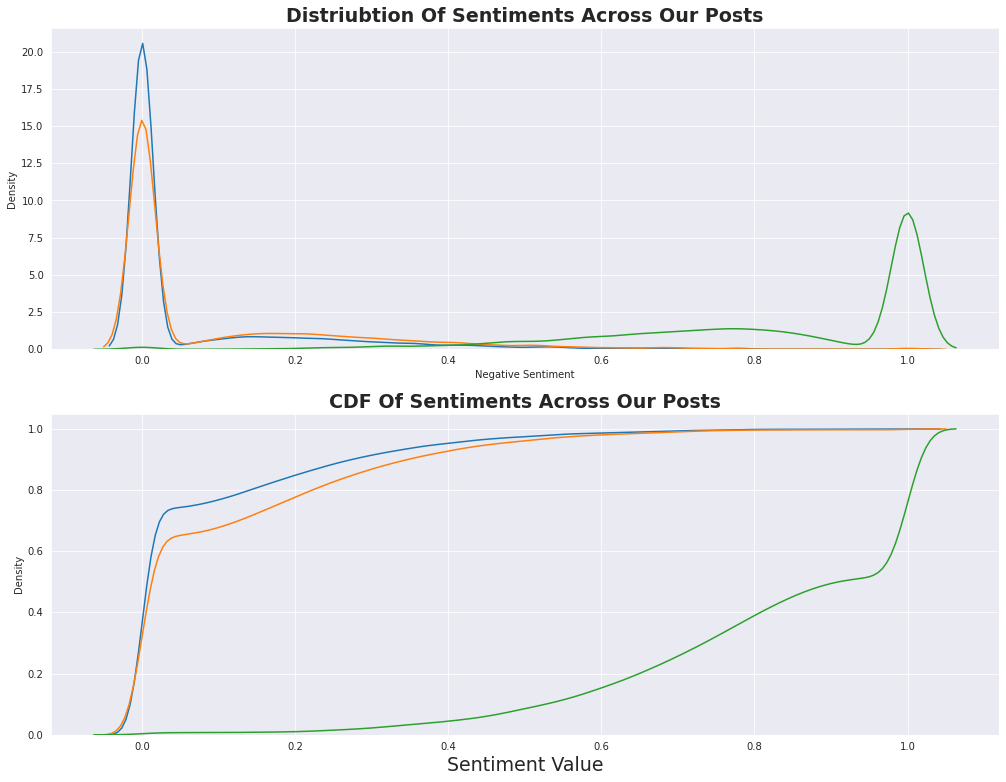

In [ ]:
plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(title_data['Negative Sentiment'],bw_method=0.1)
sns.kdeplot(title_data['Positive Sentiment'],bw_method=0.1)
sns.kdeplot(title_data['Neutral Sentiment'],bw_method=0.1)
plt.subplot(2,1,2)
plt.title('CDF Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(title_data['Negative Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(title_data['Positive Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(title_data['Neutral Sentiment'],bw_method=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()


In [ ]:
#Sorting And Feature Engineering
f_data = title_data.sort_values(by='timestamp')
ft_data=f_data.copy()
ft_data = ft_data.rename(columns={'timestamp':'date'})
ft_data['year']         = pd.DatetimeIndex(ft_data['date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1


In [ ]:
f_data=f_data.reset_index().drop(columns=['index'])
f_data = f_data.rename(columns={'timestamp':'date'})

partitions = []
partitions.append(f_data.loc[44:np.round(len(f_data)/3,0)-1,:])
partitions.append(f_data.loc[np.round(len(f_data)/3,0):2*int(len(f_data)/3)-1,:])
partitions.append(f_data.loc[2*np.round(len(f_data)/3,0):3*int(len(f_data)/3)-1,:])

neg_part_means =[]
neg_part_std   =[]
pos_part_means =[]
pos_part_std   =[]
for part in partitions:
    neg_part_means.append(part['Negative Sentiment'].mean())
    neg_part_std.append(part['Negative Sentiment'].std())
    pos_part_means.append(part['Positive Sentiment'].mean())
    pos_part_std.append(part['Positive Sentiment'].std())
    
res_df = pd.DataFrame({'Positive Sentiment Mean':pos_part_means,'Negative Sentiment Mean':neg_part_means,'Positive Sentiment SD':pos_part_std,'Negative Sentiment SD':neg_part_std},
                     index = [f'Partition_{i}' for i in range(1,4)])


def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition_1_Mean'] == temp['Partition_2_Mean'])
    m2 = (temp['Partition_1_SD'] == temp['Partition_2_SD'])
    m3 = (temp['Partition_1_Mean'] < temp['Partition_2_Mean']+3) & (temp['Partition_1_Mean'] > temp['Partition_2_Mean']-3)
    m4 = (temp['Partition_1_SD'] < temp['Partition_2_SD']+3) & (temp['Partition_1_SD'] > temp['Partition_2_SD']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition_1_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_Mean'])

    df1['Partition_1_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_SD'])

    return df1



#res_df.style.apply(highlight_greater,axis=None)
res_df = res_df.T
res_df = pd.DataFrame(res_df.values,columns=res_df.columns,index=['Positive Sentiment','Negative Sentiment','Positive Sentiment','Negative Sentiment'])
res_df = pd.concat([res_df.iloc[:2,:],res_df.iloc[2:,:]],axis=1)
res_df.columns = ['Partition_1_Mean','Partition_2_Mean','Partition_3_Mean','Partition_1_SD','Partition_2_SD','Partition_3_SD']
res_df.style.apply(highlight_greater,axis=None)


,Partition_1_Mean,Partition_2_Mean,Partition_3_Mean,Partition_1_SD,Partition_2_SD,Partition_3_SD
Positive Sentiment,0.073664,0.099328,0.126382,0.149856,0.164757,0.184143
Negative Sentiment,0.082071,0.073449,0.052059,0.157661,0.145648,0.123294


In [ ]:
fig = make_subplots(rows=3, cols=2)

for idx,prt in enumerate(partitions):
    by_date = prt.groupby(by='date').mean().reset_index()
    fig.add_trace(
    go.Scatter(x=by_date['date'], y=by_date['Positive Sentiment'],name=f'Positive Part {idx+1}'),
    row=idx+1, col=1)
    fig.add_trace(
    go.Scatter(x=by_date['date'], y=by_date['Negative Sentiment'],name=f'Negative Part {idx+1}'),
    row=idx+1, col=2)

fig.update_layout(height=600, width=900, title_text="Distibution Of Daily Mean Sentiments Over Our Time Line For Each Partition")
fig.show()

In [ ]:
fig = make_subplots(rows=4, cols=2, subplot_titles=('Observed Pos', 'Observed Neg', 'Trend Pos','Trend Neg','Seasonal Pos','Seasonal Neg','Residual Pos','Residual Neg'))
b_date_mean = ft_data.groupby(by='date').mean().reset_index()

lbl = ['Positive','Negative']

for idx,column in enumerate(['Positive Sentiment','Negative Sentiment']):
    res = seasonal_decompose(b_date_mean[column], period=5, model='additive', extrapolate_trend='freq')
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.observed)), y=res.observed,name='{} Observed'.format(lbl[idx])),
    row=1, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.trend)), y=res.trend,name='{} Trend'.format(lbl[idx])),
    row=2, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.seasonal)), y=res.seasonal,name='{} Seasonal'.format(lbl[idx])),
    row=3, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.resid)), y=res.resid,name='{} Residual'.format(lbl[idx])),
    row=4, col=idx+1)
            
fig.update_layout(height=600, width=900, title_text="Decomposition Of Our Sentiments into Trend,Level,Seasonality and Residuals")

fig.show()

TypeError: ignored

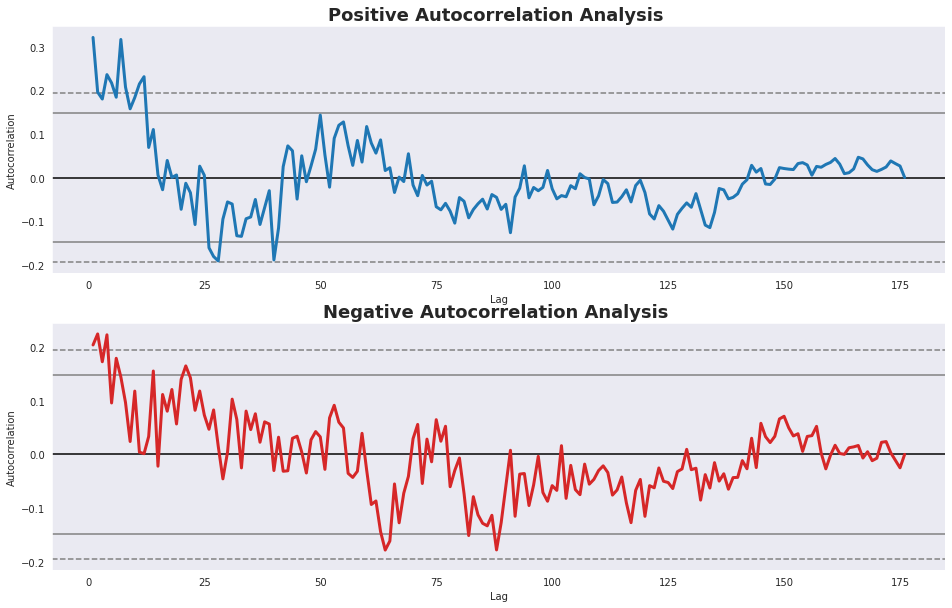

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

ax[0].set_title('Positive Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Positive Sentiment'],ax=ax[0],lw=3)
ax[1].set_title('Negative Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Negative Sentiment'],ax=ax[1],color='tab:red',lw=3)
plt.show()


In [ ]:
b_date_mean = ft_data.groupby(by='date').mean().reset_index()
b_date_std = ft_data.groupby(by='date').std().reset_index()


fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Positive Sentiment',  'Daily Average Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Positive Sentiment'],name='Positive Sentiment Mean'),
    row=1, col=1
)

    
#positive mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Positive Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean'
)




fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Negative Sentiment'],name='Negative Sentiment Mean'),
    row=2, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Negative Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)


fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Average Change With Time")
fig.show()

In [ ]:

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))
colorscale=     [[1.0              , "rgb(165,0,38)"],
                [0.8888888888888888, "rgb(215,48,39)"],
                [0.7777777777777778, "rgb(244,109,67)"],
                [0.6666666666666666, "rgb(253,174,97)"],
                [0.5555555555555556, "rgb(254,224,144)"],
                [0.4444444444444444, "rgb(224,243,248)"],
                [0.3333333333333333, "rgb(171,217,233)"],
                [0.2222222222222222, "rgb(116,173,209)"],
                [0.1111111111111111, "rgb(69,117,180)"],
                [0.0               , "rgb(49,54,149)"]]

s_val =f_data.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1,colorscale=colorscale),
    row=1, col=1
)


s_val =f_data.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale),
    row=2, col=1
)

fig.update_layout(height=700, width=900, title_text="Locations That Contribute The Most To Our Cut-Offs")
fig.show()